In [1]:
"""
Avellaneda & Lee (2010)-style statistical arbitrage on S&P 100
ETF-factor model with Yahoo Finance data.

Universe: fixed S&P 100 list (provided by user)
Data: 2022-01-01 to 2025-12-31
Backtest: 2025
"""

import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

# ============================================================
# 1. CONFIG
# ============================================================

# --- Universe (BRK.B removed because Yahoo is annoying about it) ---
SP100_TICKERS = [
    "AAPL","ABBV","ABT","ACN","ADBE","AIG","AMD","AMGN","AMT","AMZN",
    "AVGO","AXP","BA","BAC","BK","BKNG","BLK","BMY","C",
    "CAT","CL","CMCSA","COF","COP","COST","CRM","CSCO","CVS","CVX",
    "DE","DHR","DIS","DUK","EMR","FDX","GD","GE","GILD","GM",
    "GOOG","GOOGL","GS","HD","HON","IBM","INTC","INTU","ISRG","JNJ",
    "JPM","KO","LIN","LLY","LMT","LOW","MA","MCD","MDLZ","MDT",
    "MET","META","MMM","MO","MRK","MS","MSFT","NEE","NFLX","NKE",
    "NOW","NVDA","ORCL","PEP","PFE","PG","PLTR","PM","PYPL","QCOM",
    "RTX","SBUX","SCHW","SO","SPG","T","TGT","TMO","TMUS","TSLA",
    "TXN","UBER","UNH","UNP","UPS","USB","V","VZ","WFC","WMT","XOM",
]

# --- Sector ETFs (SPDR Select Sectors) ---
SECTOR_ETFS = [
    "XLE","XLF","XLK","XLV","XLY","XLP","XLI","XLB","XLU","XLC","XLRE"
]

MARKET_ETF = "SPY"  # optional, not strictly used here

# --- Map each stock to one sector ETF ---
SECTOR_ETF_MAP = {
    # Info Tech -> XLK
    "AAPL":"XLK","ACN":"XLK","ADBE":"XLK","AMD":"XLK","AVGO":"XLK",
    "CRM":"XLK","CSCO":"XLK","IBM":"XLK","INTC":"XLK","INTU":"XLK",
    "MSFT":"XLK","NOW":"XLK","NVDA":"XLK","ORCL":"XLK","PLTR":"XLK",
    "QCOM":"XLK","TXN":"XLK",

    # Health Care -> XLV
    "ABBV":"XLV","ABT":"XLV","AMGN":"XLV","CVS":"XLV","DHR":"XLV",
    "GILD":"XLV","ISRG":"XLV","JNJ":"XLV","LLY":"XLV","MDT":"XLV",
    "MRK":"XLV","PFE":"XLV","TMO":"XLV","UNH":"XLV",

    # Financials -> XLF
    "AIG":"XLF","AXP":"XLF","BAC":"XLF","BK":"XLF","BLK":"XLF",
    "C":"XLF","COF":"XLF","GS":"XLF","JPM":"XLF","MA":"XLF",
    "MET":"XLF","MS":"XLF","PYPL":"XLF","SCHW":"XLF","USB":"XLF",
    "V":"XLF","WFC":"XLF",

    # Real Estate -> XLRE
    "AMT":"XLRE","SPG":"XLRE",

    # Consumer Discretionary -> XLY
    "AMZN":"XLY","BKNG":"XLY","GM":"XLY","HD":"XLY","LOW":"XLY",
    "MCD":"XLY","NKE":"XLY","SBUX":"XLY","TGT":"XLY","TSLA":"XLY",

    # Consumer Staples -> XLP
    "CL":"XLP","COST":"XLP","KO":"XLP","MDLZ":"XLP","MO":"XLP",
    "PEP":"XLP","PG":"XLP","PM":"XLP","WMT":"XLP",

    # Communication Services -> XLC
    "CMCSA":"XLC","DIS":"XLC","GOOG":"XLC","GOOGL":"XLC",
    "META":"XLC","NFLX":"XLC","T":"XLC","TMUS":"XLC","VZ":"XLC",

    # Energy -> XLE
    "COP":"XLE","CVX":"XLE","XOM":"XLE",

    # Industrials -> XLI
    "BA":"XLI","CAT":"XLI","DE":"XLI","EMR":"XLI","FDX":"XLI",
    "GD":"XLI","GE":"XLI","HON":"XLI","LMT":"XLI","RTX":"XLI",
    "UBER":"XLI","UNP":"XLI","UPS":"XLI",

    # Materials -> XLB
    "LIN":"XLB",

    # Utilities -> XLU
    "DUK":"XLU","NEE":"XLU","SO":"XLU",
}

# Backtest & model parameters
START_DATE = "2022-01-01"
END_DATE   = "2025-12-31"

ROLLING_WINDOW = 120          # longer window for stability
ENTRY_Z = 2.0                 # more conservative entry
EXIT_Z  = 1.0                 # more conservative exit
SIGMA_FLOOR = 1e-4            # avoid exploding z-scores
TX_COST_PER_UNIT = 0.00005    # 0.5 bps per unit of turnover

# ============================================================
# 2. DOWNLOAD DATA
# ============================================================

all_tickers = sorted(set(SP100_TICKERS + SECTOR_ETFS + [MARKET_ETF]))
print(f"Downloading data for {len(all_tickers)} tickers...")
data = yf.download(
    tickers=all_tickers,
    start=START_DATE,
    end=END_DATE,
    auto_adjust=True,
    progress=True,
)

prices = data["Close"]
prices = prices.dropna(how="all")

# Returns: use log returns, don't drop rows just because 1 ticker is NaN
returns = np.log(prices / prices.shift(1))
returns = returns.dropna(how="all")

# Keep only tickers that actually downloaded
available = set(returns.columns)
universe = sorted([t for t in SP100_TICKERS if t in available and t in SECTOR_ETF_MAP])
sector_etfs_available = sorted([e for e in SECTOR_ETFS if e in available])

print(f"\nUniverse tickers available: {len(universe)}")
print(f"Sector ETFs available: {sector_etfs_available}")

stock_returns = returns[universe]
etf_returns   = returns[sector_etfs_available]

# ============================================================
# 3. ETF-FACTOR RESIDUALS (rolling regressions)
# ============================================================

dates = stock_returns.index
residuals = pd.DataFrame(index=dates, columns=universe, dtype=float)

print("\nComputing ETF-factor residuals...")
for idx in range(ROLLING_WINDOW, len(dates)):
    date = dates[idx]
    window = dates[idx-ROLLING_WINDOW:idx]

    for ticker in universe:
        sector_etf = SECTOR_ETF_MAP[ticker]
        if sector_etf not in etf_returns.columns:
            residuals.loc[date, ticker] = np.nan
            continue

        y = stock_returns.loc[window, ticker]
        x = etf_returns.loc[window, sector_etf]

        # require decent amount of non-NaN data
        mask = y.notna() & x.notna()
        if mask.sum() < 0.7 * ROLLING_WINDOW:
            residuals.loc[date, ticker] = np.nan
            continue

        y_ = y[mask].values
        x_ = x[mask].values

        x_mean = x_.mean()
        y_mean = y_.mean()
        cov_xy = np.mean((x_ - x_mean) * (y_ - y_mean))
        var_x  = np.mean((x_ - x_mean)**2)
        if var_x <= 0:
            residuals.loc[date, ticker] = np.nan
            continue

        beta  = cov_xy / var_x
        alpha = y_mean - beta * x_mean

        x_t = etf_returns.loc[date, sector_etf]
        y_t = stock_returns.loc[date, ticker]
        if pd.isna(x_t) or pd.isna(y_t):
            residuals.loc[date, ticker] = np.nan
        else:
            residuals.loc[date, ticker] = y_t - (alpha + beta * x_t)

print("Residuals done.")

# ============================================================
# 4. S-SCORES
# ============================================================

mu_resid    = residuals.rolling(window=ROLLING_WINDOW, min_periods=60).mean()
sigma_resid = residuals.rolling(window=ROLLING_WINDOW, min_periods=60).std()
sigma_resid = sigma_resid.clip(lower=SIGMA_FLOOR)

s_scores = (residuals - mu_resid) / sigma_resid

# Backtest in 2025 only
test_mask  = (dates >= "2025-01-01") & (dates <= "2025-12-31")
test_dates = dates[test_mask]
s_scores_test = s_scores.loc[test_dates]

print("\nS-score test window shape:", s_scores_test.shape)

# ============================================================
# 5. POSITIONS (discrete +/-1/0)
# ============================================================

positions = pd.DataFrame(index=test_dates, columns=universe, dtype=float)
positions.iloc[0] = 0.0

for i, date in enumerate(test_dates):
    if i == 0:
        prev_pos = positions.iloc[0].copy()
    else:
        prev_pos = positions.iloc[i-1].copy()

    current_pos = prev_pos.copy()

    for ticker in universe:
        s = s_scores.loc[date, ticker]
        if pd.isna(s):
            # If we have no signal, slowly decay position to 0
            current_pos[ticker] = prev_pos[ticker] * 0.9
            continue

        # Entry rules
        if s < -ENTRY_Z:
            current_pos[ticker] = 1.0
        elif s > ENTRY_Z:
            current_pos[ticker] = -1.0
        # Exit rule
        elif abs(s) < EXIT_Z:
            current_pos[ticker] = 0.0
        # else: hold previous

    positions.iloc[i] = current_pos

# ============================================================
# 6. CONVERT POSITIONS → DOLLAR-NEUTRAL WEIGHTS
# ============================================================

weights = pd.DataFrame(index=test_dates, columns=universe, dtype=float)

for date in test_dates:
    pos = positions.loc[date]
    long_mask  = pos > 0
    short_mask = pos < 0

    w = pd.Series(0.0, index=universe)

    n_long  = long_mask.sum()
    n_short = short_mask.sum()

    if n_long > 0:
        w_long = 0.5 / n_long  # 50% gross on long side
        w[long_mask] = w_long
    if n_short > 0:
        w_short = -0.5 / n_short
        w[short_mask] = w_short

    weights.loc[date] = w

# ============================================================
# 7. DAILY RETURNS WITH TRANSACTION COSTS
# ============================================================

strategy_returns = pd.Series(index=test_dates, dtype=float)

prev_w = pd.Series(0.0, index=universe)

for date in test_dates:
    # apply yesterday's weights to today's returns
    r = stock_returns.loc[date, universe]
    gross_ret = np.nansum(prev_w * r)

    # turnover and costs (L1 norm of weight change)
    w_today = weights.loc[date]
    turnover = np.nansum(np.abs(w_today - prev_w))
    cost = TX_COST_PER_UNIT * turnover

    strategy_returns.loc[date] = gross_ret - cost
    prev_w = w_today

[*********************100%***********************]  112 of 112 completed



Universe tickers available: 98
Sector ETFs available: ['XLB', 'XLC', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLRE', 'XLU', 'XLV', 'XLY']

Computing ETF-factor residuals...
Residuals done.

S-score test window shape: (225, 98)


In [2]:

# ============================================================
# 8. PERFORMANCE METRICS
# ============================================================

def annualized_sharpe(returns_series, periods_per_year=252):
    mu = returns_series.mean()
    sigma = returns_series.std()
    if sigma == 0 or pd.isna(sigma):
        return np.nan
    return np.sqrt(periods_per_year) * mu / sigma

def max_drawdown(equity_curve):
    cum_max = equity_curve.cummax()
    dd = (equity_curve - cum_max) / cum_max
    return dd.min()

equity = (1 + strategy_returns.fillna(0)).cumprod()

sr  = annualized_sharpe(strategy_returns.dropna())
mdd = max_drawdown(equity)
tot_ret = equity.iloc[-1] - 1

print("\n=== Backtest Results (2025, ETF-factor stat-arb) ===")
print(f"Annualized Sharpe Ratio: {sr:.3f}")
print(f"Total Return: {tot_ret:.2%}")
print(f"Max Drawdown: {mdd:.2%}")


=== Backtest Results (2025, ETF-factor stat-arb) ===
Annualized Sharpe Ratio: -0.713
Total Return: -10.24%
Max Drawdown: -18.54%


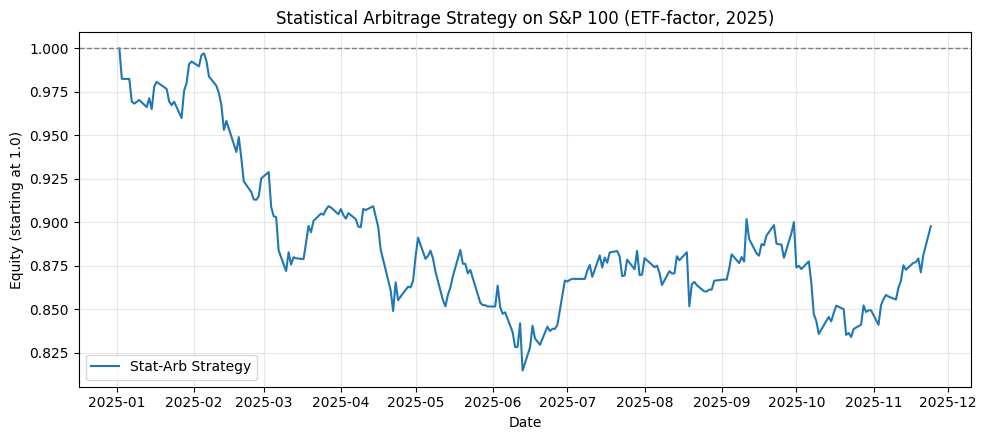

In [3]:

# ============================================================
# 9. PLOT EQUITY CURVE
# ============================================================

plt.figure(figsize=(10, 4.5))
plt.plot(equity.index, equity.values, label="Stat-Arb Strategy")
plt.axhline(1.0, color="gray", linestyle="--", linewidth=1)
plt.title("Statistical Arbitrage Strategy on S&P 100 (ETF-factor, 2025)")
plt.xlabel("Date")
plt.ylabel("Equity (starting at 1.0)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
